# Fused Softmax

In [ ]:
import torch
import triton
import triton.language as tl

## L1

In [45]:
@torch.jit.script
def naive_softmax(x):
    # read: MN, write: M
    x_max = x.max(dim=1)[0].unsqueeze(1)
    # read: MN + M, write: MN
    z = x - x_max
    # read: MN, write: MN
    numerator = torch.exp(z)
    # read: MN, write M
    denominator = numerator.sum(dim=1).unsqueeze(1)
    # read: MN + M, write MN
    ret = numerator / denominator
    # total read:5MN + 2M, write: 3MN + 2M
    return ret


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    row_idx = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    input_ptrs = input_ptr + row_idx * input_row_stride + col_offsets
    x = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    x_minus_max = x - tl.max(x, axis=0)
    num = tl.exp(x_minus_max)
    deno = tl.sum(num, axis=0)
    y = num / deno

    output_ptrs = output_ptr + row_idx * output_row_stride + col_offsets
    tl.store(output_ptrs, y, mask=mask)


def softmax(x):
    n_rows, n_cols = x.size()
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)
    softmax_kernel[(n_rows,)](
        x,
        y,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )

    return y


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
y_triton = softmax(x)
assert torch.allclose(y_torch, y_triton), (y_naive, y_triton)

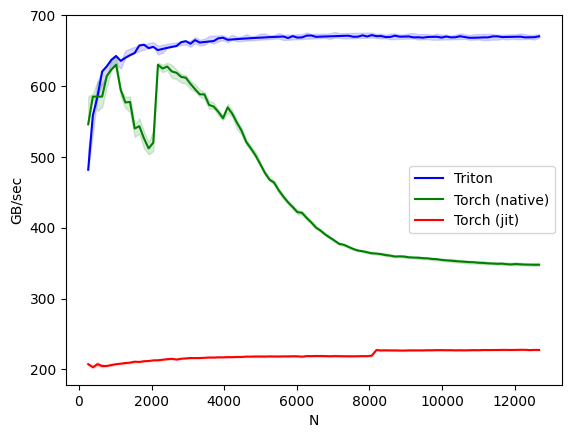

softmax-performance-plot:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  481.882344      546.133347   207.392411
1     384.0  558.545450      585.142862   203.107443
2     512.0  585.142849      585.142849   207.392411
3     640.0  620.606056      585.142842   204.800005
4     768.0  627.889825      614.400016   204.800005
..      ...         ...             ...          ...
93  12160.0  669.741824      348.361681   227.688710
94  12288.0  668.734699      347.978764   227.681135
95  12416.0  668.875440      347.908942   227.295189
96  12544.0  669.013302      347.689891   227.555550
97  12672.0  670.254536      347.773576   227.427936

[98 rows x 4 columns]


In [21]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * x for x in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-native", "torch-naive"],
        line_names=["Triton", "Torch (native)", "Torch (jit)"],
        styles=[("blue", "-"), ("green", "-"), ("red", "-")],
        ylabel="GB/sec",
        plot_name="softmax-performance-plot",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles
        )
    if provider == "torch-naive":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: naive_softmax(x), quantiles=quantiles
        )
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )

    gbps = lambda ms: 2 * (x.numel() * x.element_size() / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L2

In [52]:
@torch.jit.script
def softmax_naive(x):
    # read: MN, write: M
    x_max = torch.max(x, dim=1)[0].unsqueeze(1)

    # read: MN + M, write: MN
    x_min_max = x - x_max

    # read: MN, write: MN
    num = torch.exp(x_min_max)

    # read: MN, write: M
    deno = torch.sum(num, dim=1).unsqueeze(1)

    # read: MN + M, write: MN
    y = num / deno

    # read: 5MN + 2M, write: 3MN + 2M
    return y


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    row_id = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    input_ptrs = input_ptr + row_id * input_row_stride + col_offsets
    x = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    x_minus_max = x - tl.max(x, axis=0)
    num = tl.exp(x_minus_max)
    deno = tl.sum(num, axis=0)
    y = num / deno

    output_ptrs = output_ptr + row_id * output_row_stride + col_offsets
    tl.store(output_ptrs, y, mask=mask)


def softmax(x):
    rows, cols = x.size()
    BLOCK_SIZE = triton.next_power_of_2(cols)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)
    softmax_kernel[(rows,)](
        x, y, x.stride(0), y.stride(0), cols, BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps
    )
    return y


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_naive, y_torch)
y_triton = softmax(x)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

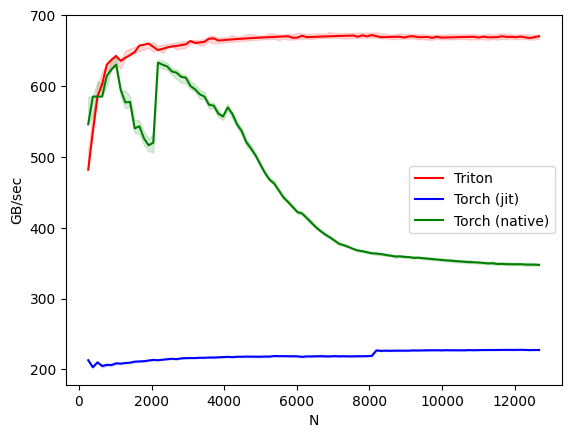

softmax-performance-plot:
          N      Triton  Torch (jit)  Torch (native)
0     256.0  481.882344   213.038613      546.133347
1     384.0  535.716620   203.107443      585.142862
2     512.0  585.142849   209.967167      585.142849
3     640.0  602.352931   204.800005      585.142842
4     768.0  630.153868   206.521014      614.400016
..      ...         ...          ...             ...
93  12160.0  669.741824   227.688710      348.542074
94  12288.0  668.734699   227.555555      347.978764
95  12416.0  667.751271   227.295189      347.908942
96  12544.0  669.013302   227.430657      347.840538
97  12672.0  670.237190   227.427936      347.489537

[98 rows x 4 columns]


In [53]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * x for x in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-naive", "torch-native"],
        line_names=["Triton", "Torch (jit)", "Torch (native)"],
        styles=[("red", "-"), ("blue", "-"), ("green", "-")],
        ylabel="GB/sec",
        plot_name="softmax-performance-plot",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles
        )
    if provider == "torch-naive":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax_naive(x), quantiles=quantiles
        )

    gbps = lambda ms: 2 * (x.numel() * x.element_size() / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L3

In [57]:
@torch.jit.script
def softmax_naive(x):
    # read: MN, write: M
    x_max = x.max(dim=1)[0].unsqueeze(1)

    # read: MN, write: MN
    x = x - x_max

    # read: MN, write: MN
    num = torch.exp(x)

    # read: MN, write: M
    den = torch.sum(num, dim=1).unsqueeze(1)

    # read: MN + M, write: MN
    y = num / den

    return y


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    idx = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n

    input_ptrs = 


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_naive, y_torch)